In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

In [3]:
import pickle
import emot
import emoji

In [4]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Beolvasás/korrekció

In [5]:
data = pd.read_csv("challengeThinkingTrainingData-corrected.csv", error_bad_lines=False)

b'Skipping line 349: expected 28 fields, saw 29\nSkipping line 7562: expected 28 fields, saw 29\nSkipping line 9079: expected 28 fields, saw 29\nSkipping line 12452: expected 28 fields, saw 30\nSkipping line 12666: expected 28 fields, saw 29\n'


In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
data[["lastmood", "lastGad7", "lastPhq8"]]=data[["lastmood", "lastGad7", "lastPhq8"]].replace(-1,np.nan)
data["timeonplatform_hrs"]=data["timeonplatform"]/3600000

In [8]:
print("Number of rows in data =", data.shape[0])
print("Number of columns in data=", data.shape[1])
print("\n")
print("Sample data:")
data.head()

Number of rows in data = 14290
Number of columns in data= 29


Sample data:


,thought,timeonplatform,lastmood,lastPhq8,lastGad7,age,gender,inTherapy,location,distortion0,...,distortion10,typeofthought0,typeofthought1,typeofthought2,typeofthought3,typeofthought4,typeofthought5,typeofthought6,typeofthought7,timeonplatform_hrs
0,Im a lazy mooch,1461044082.21,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1,...,0,1,0,1,0,1,1,1,1,405.85
1,Lose weight,1198910277.11,4.00,NaN,NaN,NaN,NaN,NaN,America/New_York,0,...,1,0,0,0,1,1,0,1,0,333.03
2,I need to make up my mind,1231907449.04,3.00,NaN,NaN,NaN,NaN,NaN,America/Chicago,1,...,1,0,0,0,1,1,0,0,0,342.20
3,I'm angry how my work treated me recently,967828.19,2.00,NaN,NaN,NaN,NaN,NaN,America/New_York,0,...,0,0,0,0,0,0,0,0,0,0.27
4,My work doesn't value me,3278514508.48,4.00,NaN,NaN,NaN,NaN,NaN,America/New_York,0,...,0,0,0,0,0,0,0,0,0,910.70


## Aggregált statisztika

In [9]:
data["age"].value_counts(dropna=False)

NaN      9751
25-34    1479
18-24    1362
35-44     916
45-54     470
55-64     286
65+        26
Name: age, dtype: int64

In [289]:
(1479 + 1362)/(1479 + 1362 + 916 + 470 + 286 + 26)

0.6259087904824852

In [10]:
data["timeonplatform_hrs"].describe()

count   14290.00
mean      786.23
std      1210.93
min         0.05
25%        46.44
50%       294.00
75%      1000.11
max     10150.78
Name: timeonplatform_hrs, dtype: float64

In [11]:
data["gender"].value_counts(dropna=False)

NaN       9665
Female    3485
Male       932
Other      208
Name: gender, dtype: int64

In [288]:
3485/(932+208+3485)

0.7535135135135135

In [286]:
9700/len(data)

0.6787963610916725

In [12]:
data["lastmood"].value_counts(dropna=False)

3.00    3749
2.00    3419
4.00    2641
1.00    2083
NaN     1957
0.00     441
Name: lastmood, dtype: int64

In [13]:
data[["lastGad7", "lastPhq8"]].describe()

,lastGad7,lastPhq8
count,3796.00,3089.00
mean,9.28,9.84
std,4.61,5.20
min,0.00,0.00
25%,6.00,6.00
50%,9.00,10.00
75%,13.00,14.00
max,18.00,21.00


In [14]:
data["inTherapy"].value_counts(dropna=False)

NaN    12044
No      1407
Yes      839
Name: inTherapy, dtype: int64

In [15]:
data["location"].value_counts(dropna=False)[:20]

Europe/London          2679
America/New_York       2604
America/Chicago        1773
America/Los_Angeles    1026
Asia/Calcutta           501
America/Toronto         478
Europe/Berlin           440
America/Denver          340
Australia/Sydney        267
Africa/Johannesburg     227
Asia/Manila             180
Europe/Paris            169
Europe/Amsterdam        158
Europe/Rome             150
America/Halifax         142
America/Edmonton        137
Europe/Warsaw           129
America/Vancouver       108
America/Phoenix         104
Europe/Brussels          99
Name: location, dtype: int64

In [283]:
(len(data) - (500 + 180 + 200)) / len(data)

0.9384184744576627

## Tisztítás

### Kisbetű és no központozás

In [16]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [17]:
data['thought'] = data['thought'].str.lower()
data['thought'] = data['thought'].apply(cleanPunc)

### Emojik átkódolása

In [18]:
with open('../Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

In [19]:
def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

In [20]:
updated_thoughts = []
for thought in data['thought']:
    if(bool(emoji.get_emoji_regexp().search(thought))):
        updated_thoughts.append(convert_emojis_to_word(thought))
    else:
        updated_thoughts.append(thought)

In [21]:
data_w_emoji2w = data.copy()

In [22]:
data_w_emoji2w['thought'] = updated_thoughts

### Speciális karakterek eltávolítása

In [23]:
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [24]:
data_no_special_ch = data_w_emoji2w.copy()

In [25]:
data_no_special_ch['thought'] = data_no_special_ch['thought'].apply(keepAlpha)

### Instrukciók eltávolítása

In [26]:
data_no_special_ch = data_no_special_ch[data_no_special_ch['thought'] != 'skip']
data_no_special_ch = data_no_special_ch[data_no_special_ch['thought'] != 'skip more detail']
data_no_special_ch = data_no_special_ch[data_no_special_ch['thought'] != ""]

### Rövidítések kicserélése

In [27]:
thoughts = [];
for i in data_no_special_ch['thought']:
    sentence = '';
    for word in i.split(' '):
        if (word == 'im'):
            sentence += 'i am '
        elif (word == 'm'):
            sentence += 'am '
        elif (word == 't'):
            sentence += 'not '
        elif (word == 'isnt'):
            sentence += 'is not '
        elif (word == 'wasnt'):
            sentence += 'was not '
        elif (word == 'werent'):
            sentence += 'was not '
        elif (word == 'doesnt'):
            sentence += 'does not '
        elif (word == 'dont'):
            sentence += 'do not '
        elif (word == 'cant'):
            sentence += 'can not '
        elif (word == 'wont'):
            sentence += 'wil not '
        elif (word == 'ive'):
            sentence += 'i have '
        elif (word == 'couldnt'):
            sentence += 'could not '
        elif (word == 'shouldnt'):
            sentence += 'should not '
        elif (word == 'don'):
            sentence += 'do '
        elif (word == 'll'):
            sentence += 'will '
        elif (word == 'won'):
            sentence += 'will '
        elif (word == 'doesn'):
            sentence += 'does '
        elif (word == 'couldn'):
            sentence += 'could '
        elif (word == 'theres'):
            sentence += 'there is '
        elif (word == 's'):
            sentence += 'is '
        elif (word == 'its'):
            sentence += 'it is '
        else:
            sentence += word + ' '
    thoughts.append(sentence)

In [28]:
cleared_data = data_no_special_ch.copy()

In [29]:
cleared_data['thought'] = thoughts

### Remove white space

In [30]:
cleared_data['thought'] = cleared_data['thought'].str.strip()

# Interannotatori egyetértés

In [202]:
from sklearn.metrics import cohen_kappa_score

In [268]:
iaa = cleared_data[cleared_data['thought']=='i never get enough done'][distortion_list]

In [276]:
kappas = []
for i in range(100):
    egy, ket = np.random.choice(29, 2)
    kappas.append(cohen_kappa_score(iaa.iloc[egy], iaa.iloc[ket]))

In [277]:
sum(kappas)/len(kappas)

0.15193553721797934

## Duplikáltak közül domináns kiválasztása

In [31]:
v = cleared_data["thought"].value_counts(dropna=False)

In [32]:
thoughts_list = list(v.index[v.gt(0)])

In [33]:
distortion_list = ["distortion0","distortion1","distortion2","distortion3","distortion4","distortion5","distortion6","distortion7","distortion8","distortion9","distortion10"]

In [34]:
revised_events = []
for thought in thoughts_list:
    related_data = cleared_data[cleared_data["thought"]==thought]
    new_distortion_vector = []
    for label in distortion_list:
        if len(related_data[label].mode()) == 1:
            new_distortion_vector.append(related_data[label].mode()[0])
        else:
            id_of_max = related_data[["timeonplatform",label]]["timeonplatform"].idxmax()
            new_distortion_vector.append(int(related_data[["timeonplatform",label]].loc[id_of_max][1]))
    id_max_global = related_data["timeonplatform"].idxmax()
    new_event = related_data.loc[id_max_global].copy()
    new_event[distortion_list] = new_distortion_vector
    revised_events.append(new_event)

In [35]:
bt_defined_data = pd.DataFrame(revised_events)

In [36]:
bt_defined_data.to_csv("/Users/matesal/Learning/IONA/final_analysis/out.csv", index=False)

In [284]:
bt_defined_data

,thought,timeonplatform,lastmood,lastPhq8,lastGad7,age,gender,inTherapy,location,distortion0,...,distortion10,typeofthought0,typeofthought1,typeofthought2,typeofthought3,typeofthought4,typeofthought5,typeofthought6,typeofthought7,timeonplatform_hrs
3904,i am not good enough,19598842125.65,1.00,NaN,NaN,25-34,Male,NaN,Europe/London,1,...,1,1,0,0,0,1,1,1,1,5444.12
6440,i am a failure,26297270404.23,1.00,NaN,NaN,35-44,Female,NaN,America/New_York,1,...,0,1,0,0,1,1,1,1,1,7304.80
16,i am worthless,18131973480.85,4.00,7.00,10.00,18-24,Female,Yes,America/New_York,0,...,0,0,0,0,0,1,0,0,1,5036.66
321,i am useless,17737195130.73,3.00,NaN,NaN,NaN,NaN,NaN,Europe/Stockholm,1,...,0,0,0,0,0,1,0,1,0,4927.00
11078,i am not enough,15970234607.18,NaN,NaN,NaN,NaN,NaN,NaN,America/Denver,1,...,1,1,0,0,1,1,1,1,0,4436.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807,todays going to suck,3096040767.64,3.00,7.00,NaN,NaN,Female,No,America/Los_Angeles,0,...,1,0,0,0,1,1,1,1,1,860.01
4808,i think i am useless,587128.82,NaN,NaN,NaN,NaN,NaN,NaN,Europe/Berlin,0,...,0,0,0,0,1,0,0,1,1,0.16
4809,my future is uncertain right now there is too ...,7525058523.11,2.00,NaN,NaN,NaN,NaN,NaN,Asia/Calcutta,0,...,0,0,0,0,1,0,1,0,0,2090.29
4811,i havent accomplished anything good enough in ...,1030010.19,4.00,NaN,NaN,NaN,NaN,NaN,America/Los_Angeles,1,...,0,0,0,0,0,1,1,1,0,0.29


## Stemming

In [37]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [38]:
stemmed_data = bt_defined_data.copy()

In [39]:
stemmed_data['thought'] = bt_defined_data['thought'].apply(stemming)

## Lexicon

In [37]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [38]:
lexicon_normal = flatten(list(bt_defined_data["thought"].str.split(" ").to_numpy()))

In [39]:
lexicon_stemmed = flatten(list(stemmed_data["thought"].str.split(" ").to_numpy()))

NameError: name 'stemmed_data' is not defined

In [41]:
sum(pd.DataFrame(pd.DataFrame(lexicon_normal).value_counts(dropna=False))[0] >= 1)

5819

In [42]:
sum(pd.DataFrame(pd.DataFrame(lexicon_stemmed).value_counts(dropna=False))[0] == 1)

NameError: name 'lexicon_stemmed' is not defined

## Grafikonok

### Labelek eloszlása

In [43]:
distortion_data = bt_defined_data[["thought", "distortion0", "distortion1", "distortion2", "distortion3", "distortion4", "distortion5", "distortion6", "distortion7", "distortion8", "distortion9", "distortion10"]]

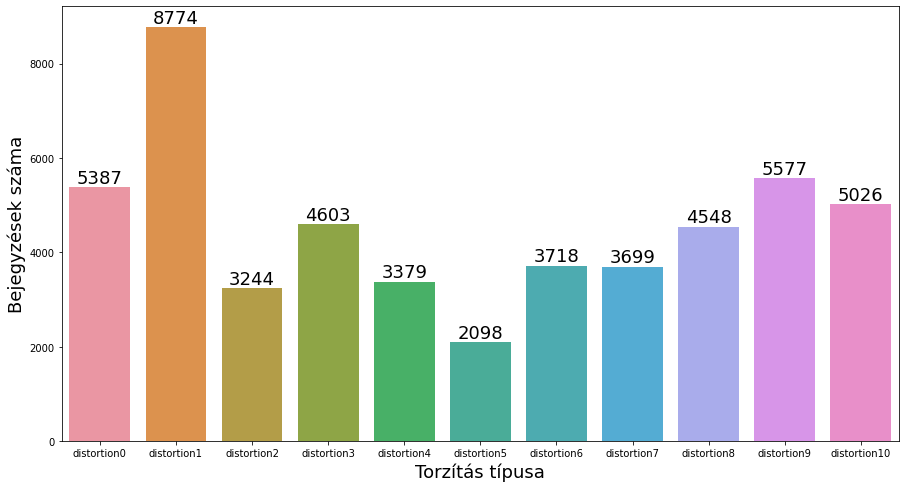

In [292]:
categories = list(distortion_data.columns.values)
plt.figure(figsize=(15,8))

ax = sns.barplot(categories[1:], distortion_data.iloc[:,1:].sum().values)

#plt.title('Torzítások eloszlása', fontsize=24)
plt.ylabel('Bejegyzések száma', fontsize=18)
plt.xlabel('Torzítás típusa', fontsize=18)

#adding text labels
rects = ax.patches
labels = distortion_data.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

In [295]:
2098/len(distortion_data)

0.18619098331558395

### Labelek számának eloszlása

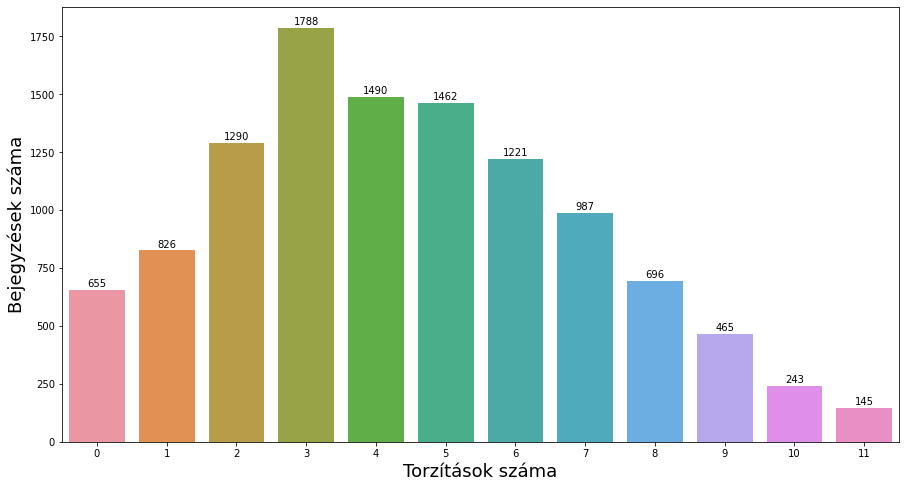

In [291]:
rowSums = distortion_data.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.sort_index()
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
#plt.title("Torzítások számának eloszlása")
plt.ylabel('Bejegyzések száma', fontsize=18)
plt.xlabel('Torzítások száma', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Label kardinalitás és sűrűség

In [46]:
# Label kardinalitás
lab_card = distortion_data[distortion_list].sum(axis=1).values.mean()
lab_card

4.442048278310259

In [47]:
# Label sűrűség
lab_card / len(distortion_list)

0.4038225707554781

### Szavak száma bejegyzésenként

In [48]:
wordcount = []
for sentence in distortion_data.thought:
    counter = 0
    for word in sentence.split(' '):
        counter += 1
    wordcount.append([sentence, counter])
wordcounts = pd.DataFrame(wordcount)
wordcounts = wordcounts.rename(columns = {0:'thought', 1:'word_count'})

In [49]:
word_count_counts = wordcounts.word_count.value_counts()

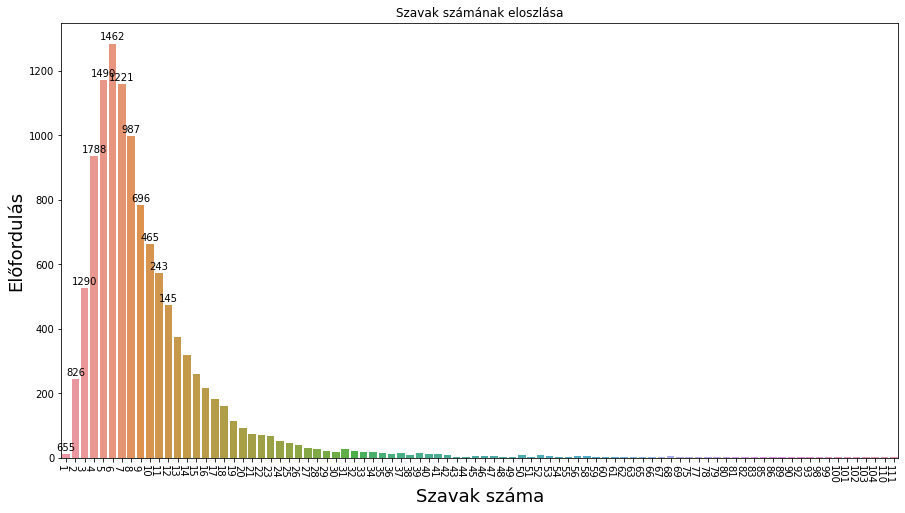

In [50]:
plt.figure(figsize=(15,8))
ax = sns.barplot(word_count_counts.index, word_count_counts.values)
plt.title("Szavak számának eloszlása")
plt.ylabel('Előfordulás', fontsize=18)
plt.xlabel('Szavak száma', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.setp(ax.get_xticklabels(), rotation=270, horizontalalignment='right')
plt.show()

In [51]:
wordcounts.word_count.describe()

count   11268.00
mean        9.90
std         8.13
min         1.00
25%         5.00
50%         8.00
75%        12.00
max       111.00
Name: word_count, dtype: float64

In [52]:
wordcounts.word_count.median()

8.0

## Tanuló és teszt adatbázis elválasztása

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
train, test = train_test_split(bt_defined_data, random_state=42, test_size=0.20, shuffle=True)

# Vektorizálás

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [56]:
no_distortion_cols = ['thought', 'timeonplatform', 'lastmood', 'lastPhq8', 'lastGad7', 'age', 'gender', 'inTherapy', 'location', 'timeonplatform_hrs']

In [57]:
y_train = train[distortion_list]

In [58]:
y_test = test[distortion_list]

## Szógyakoriság

In [59]:
countVectorizer = CountVectorizer()
countVectorizer.fit(train.thought)

CountVectorizer()

#### Tanuló halmaz

In [60]:
count_x_train = countVectorizer.transform(train.thought)

#### Teszthalmaz

In [61]:
count_x_test = countVectorizer.transform(test.thought)

## TF-IDF

In [62]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train.thought)

TfidfVectorizer()

#### Tanuló halmaz

In [63]:
tf_idf_x_train = vectorizer.transform(train.thought)

#### Teszthalmaz

In [64]:
tf_idf_x_test = vectorizer.transform(test.thought)

# Szóbeágyazás

In [65]:
from gensim.models import KeyedVectors

## Word2Vec

In [66]:
# load Googel News model
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

#### szótáron kívüli szavak kiszórása

In [67]:
out_of_vocab = []
for thought in bt_defined_data['thought']:
    thought_all_words = thought.split()
    thought_vectorized = []
    for thought_w in thought_all_words:
        if thought_w in model:
            thought_vectorized.append(model[thought_w])
    if not thought_vectorized:
        print("found")
        out_of_vocab.append(thought_w)
print(out_of_vocab)

found
found
['lihava', 'hhg']


In [68]:
train[train['thought'].isin(out_of_vocab)]

,thought,timeonplatform,lastmood,lastPhq8,lastGad7,age,gender,inTherapy,location,distortion0,...,distortion10,typeofthought0,typeofthought1,typeofthought2,typeofthought3,typeofthought4,typeofthought5,typeofthought6,typeofthought7,timeonplatform_hrs
1005,hhg,14135414241.17,2.00,NaN,NaN,NaN,NaN,NaN,Australia/Darwin,0,...,0,1,0,0,0,0,0,0,1,3926.50


In [69]:
train[train['thought'].str.contains('lihava')]

,thought,timeonplatform,lastmood,lastPhq8,lastGad7,age,gender,inTherapy,location,distortion0,...,distortion10,typeofthought0,typeofthought1,typeofthought2,typeofthought3,typeofthought4,typeofthought5,typeofthought6,typeofthought7,timeonplatform_hrs
2187,olen lihava,84871449.33,2.00,16.00,14.00,NaN,NaN,NaN,Europe/Helsinki,0,...,0,0,0,0,1,1,0,0,1,23.58


In [70]:
train_wo_oov = train.drop([1005, 2187])

#### Tanuló halmaz vektorizálása

In [71]:
w2v_x_train = []
for thought in train_wo_oov['thought']:
    thought_all_words = thought.split()
    thought_vectorized = []
    for thought_w in thought_all_words:
        if thought_w in model:
            thought_vectorized.append(model[thought_w])
    thought_vectorized_mean = np.mean(thought_vectorized, axis=0)
    w2v_x_train.append(thought_vectorized_mean)

In [72]:
w2v_x_train_df = pd.DataFrame(w2v_x_train)
w2v_x_train_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.07,0.01,0.08,0.01,-0.05,0.07,0.06,-0.01,0.05,0.11,...,-0.02,0.12,-0.12,0.00,-0.08,0.04,-0.15,-0.05,-0.00,0.02
1,-0.04,0.08,-0.01,0.10,-0.07,-0.02,0.08,-0.07,-0.02,0.06,...,-0.16,0.11,-0.14,-0.05,-0.13,-0.05,0.11,0.02,-0.01,-0.01
2,0.02,0.03,0.04,0.12,-0.07,0.02,0.05,-0.09,0.05,0.05,...,-0.02,0.08,-0.11,0.01,-0.02,-0.04,-0.00,-0.04,0.01,-0.04
3,0.08,0.08,0.03,0.07,-0.11,0.12,0.04,-0.14,0.10,0.11,...,-0.06,-0.06,-0.08,-0.06,-0.05,0.10,-0.03,0.02,-0.02,0.12
4,0.01,-0.07,0.08,0.17,-0.07,-0.00,-0.02,-0.07,0.05,0.15,...,-0.05,0.17,-0.14,0.03,-0.10,0.01,0.02,-0.01,-0.02,-0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,0.04,0.06,-0.03,0.11,-0.06,-0.03,0.10,-0.07,0.01,-0.01,...,-0.06,0.13,-0.16,0.05,-0.10,0.02,0.10,-0.07,-0.08,-0.00
9008,0.01,0.07,0.04,0.08,-0.06,0.01,0.00,-0.08,0.08,0.08,...,-0.04,0.05,-0.09,0.04,-0.02,0.03,-0.03,0.00,0.05,-0.04
9009,0.07,0.00,0.02,0.08,-0.01,-0.02,0.02,-0.10,0.04,0.07,...,-0.06,0.06,-0.11,-0.03,-0.08,-0.03,0.04,-0.05,0.04,-0.03
9010,-0.03,-0.10,-0.01,0.16,-0.11,0.06,0.09,0.01,0.05,-0.05,...,-0.07,0.11,-0.09,-0.11,-0.13,-0.01,-0.08,-0.01,-0.07,0.09


In [73]:
w2v_y_train = train_wo_oov[distortion_list]

In [74]:
w2v_y_train = w2v_y_train.reset_index().drop(["index"], axis=1)

#### Teszthalmaz vektorizálása

In [75]:
w2v_x_test = []
for thought in test['thought']:
    thought_all_words = thought.split()
    thought_vectorized = []
    for thought_w in thought_all_words:
        if thought_w in model:
            thought_vectorized.append(model[thought_w])
    thought_vectorized_mean = np.mean(thought_vectorized, axis=0)
    w2v_x_test.append(thought_vectorized_mean)

In [76]:
w2v_x_test_df = pd.DataFrame(w2v_x_test)
w2v_x_test_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.00,0.01,0.06,0.11,-0.04,0.03,0.05,-0.04,0.04,0.06,...,-0.08,0.12,-0.11,0.01,-0.06,0.04,0.00,-0.04,0.07,-0.01
1,0.08,0.01,0.03,0.10,-0.10,0.04,0.04,-0.06,0.05,0.08,...,0.03,0.13,-0.07,0.00,-0.07,-0.06,-0.11,0.01,-0.01,-0.02
2,0.02,-0.04,0.01,0.08,-0.06,0.05,0.00,-0.02,0.12,-0.04,...,0.06,0.11,-0.15,-0.04,-0.04,0.01,-0.05,-0.04,0.01,-0.06
3,-0.08,0.03,0.02,0.14,-0.05,0.03,-0.02,-0.03,0.06,0.10,...,-0.04,0.16,-0.13,0.07,-0.12,-0.01,-0.04,0.02,-0.04,0.03
4,0.03,-0.04,0.09,0.16,-0.09,0.07,0.04,-0.08,0.01,0.10,...,-0.05,0.17,-0.25,-0.02,-0.18,-0.09,-0.03,0.01,-0.06,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,-0.03,0.02,0.04,0.18,-0.09,0.07,0.08,-0.09,0.08,0.06,...,-0.00,0.12,-0.10,-0.00,-0.08,-0.05,-0.04,0.01,-0.00,0.08
2250,0.05,-0.00,0.00,0.09,-0.08,0.03,0.03,-0.04,0.06,0.09,...,-0.09,0.09,-0.07,0.03,-0.08,-0.02,-0.13,-0.05,0.01,-0.00
2251,-0.03,-0.01,-0.03,0.11,-0.04,0.10,0.04,-0.11,0.03,0.10,...,-0.03,0.05,-0.12,0.01,-0.01,0.01,-0.12,-0.14,0.08,-0.12
2252,0.03,0.08,0.04,0.08,-0.05,0.04,0.08,-0.06,-0.01,0.04,...,-0.08,0.08,-0.15,-0.08,-0.03,-0.03,-0.07,-0.09,0.01,-0.09


In [77]:
w2v_y_test = y_test.reset_index().drop(["index"], axis=1)

## GloVe

In [78]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [79]:
glove_input_file = './glove/glove.6B.300d.txt'

In [80]:
word2vec_output_file = 'word2vec.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [81]:
# load Stanford GloVe
filename = 'word2vec.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

#### szótáron kívüli szavak kiszórása

In [82]:
out_of_vocab_glove = []
for thought in bt_defined_data['thought']:
    thought_all_words = thought.split()
    thought_vectorized = []
    for thought_w in thought_all_words:
        if thought_w in glove_model:
            thought_vectorized.append(glove_model[thought_w])
    if not thought_vectorized:
        print("found")
        out_of_vocab_glove.append(thought_w)
print(out_of_vocab_glove)

[]


#### Tanuló halmaz vektorizálása

In [83]:
glove_x_train = []
for thought in train['thought']:
    thought_all_words = thought.split()
    thought_vectorized = []
    for thought_w in thought_all_words:
        if thought_w in glove_model:
            thought_vectorized.append(glove_model[thought_w])
    thought_vectorized_mean = np.mean(thought_vectorized, axis=0)
    glove_x_train.append(thought_vectorized_mean)

In [84]:
glove_x_train_df = pd.DataFrame(glove_x_train)
glove_x_train_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.12,0.11,0.04,-0.11,-0.02,0.00,0.05,0.34,0.01,-1.69,...,0.09,-0.36,-0.02,-0.06,-0.00,-0.33,0.18,-0.18,0.09,0.20
1,-0.09,-0.04,-0.05,-0.16,0.08,-0.06,-0.15,0.04,0.08,-1.65,...,0.06,-0.24,-0.18,0.01,0.07,-0.32,0.14,-0.05,-0.20,0.33
2,-0.09,0.08,-0.12,-0.12,-0.05,0.08,-0.04,0.03,0.07,-1.56,...,0.06,-0.24,0.04,-0.01,0.13,-0.14,0.05,-0.24,-0.06,0.17
3,-0.29,0.09,0.03,-0.08,-0.05,-0.02,-0.10,-0.07,-0.07,-1.62,...,0.05,-0.15,-0.02,-0.14,-0.04,0.02,0.15,-0.01,-0.21,0.12
4,-0.14,-0.01,-0.09,-0.04,-0.10,-0.01,-0.08,-0.03,0.16,-1.69,...,0.17,-0.22,-0.15,0.09,0.14,-0.23,0.11,-0.09,-0.02,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9009,-0.12,0.06,-0.03,-0.11,-0.05,-0.03,-0.12,-0.00,0.14,-1.82,...,-0.07,-0.16,-0.02,-0.01,0.18,-0.20,0.04,-0.04,-0.08,0.17
9010,-0.01,0.07,0.03,-0.15,0.01,0.09,-0.14,0.03,0.07,-1.70,...,-0.02,-0.25,-0.05,0.05,0.08,-0.01,0.09,-0.14,0.07,0.12
9011,-0.21,0.11,-0.10,-0.06,-0.10,-0.02,-0.08,-0.10,0.09,-1.50,...,-0.04,-0.16,-0.00,-0.05,0.10,-0.12,0.11,-0.14,-0.07,0.22
9012,-0.03,0.01,0.02,-0.07,-0.05,0.11,-0.00,0.02,-0.17,-1.25,...,-0.06,-0.37,-0.11,-0.24,0.04,-0.33,0.11,0.12,0.16,0.29


In [85]:
glove_y_train = y_train.reset_index().drop(["index"], axis=1)

#### Teszt halmaz vektorizálása

In [86]:
glove_x_test = []
for thought in test['thought']:
    thought_all_words = thought.split()
    thought_vectorized = []
    for thought_w in thought_all_words:
        if thought_w in glove_model:
            thought_vectorized.append(glove_model[thought_w])
    thought_vectorized_mean = np.mean(thought_vectorized, axis=0)
    glove_x_test.append(thought_vectorized_mean)

In [87]:
glove_x_test_df = pd.DataFrame(glove_x_test)
glove_x_test_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.17,0.14,-0.12,-0.10,-0.02,-0.05,0.05,0.02,-0.04,-1.83,...,-0.02,-0.23,0.07,-0.06,0.18,-0.10,0.02,-0.20,-0.12,0.06
1,0.03,-0.02,0.07,-0.02,0.21,-0.16,0.11,0.08,0.10,-1.67,...,-0.06,-0.24,0.05,-0.21,0.19,-0.12,0.10,-0.34,0.01,0.10
2,-0.17,0.07,-0.09,-0.31,0.00,-0.08,-0.02,0.09,0.16,-1.67,...,0.06,-0.51,-0.03,-0.29,0.25,-0.06,0.09,-0.09,0.06,0.09
3,-0.04,0.10,0.03,0.00,0.07,-0.07,0.09,0.04,0.07,-1.73,...,-0.00,-0.20,0.04,0.02,0.16,-0.17,0.06,-0.35,-0.15,0.08
4,-0.12,0.03,-0.01,0.19,-0.22,0.05,-0.09,0.03,-0.09,-1.34,...,-0.02,-0.24,-0.14,-0.17,0.02,-0.66,0.23,0.08,-0.10,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,0.06,-0.01,0.14,-0.19,0.17,-0.09,0.08,0.19,0.10,-2.06,...,0.04,-0.29,-0.06,-0.04,0.23,-0.28,0.10,-0.12,0.17,0.41
2250,-0.18,0.06,-0.04,-0.08,-0.06,0.05,-0.03,-0.03,-0.01,-1.50,...,-0.01,-0.21,0.02,0.09,0.21,-0.18,0.05,-0.20,-0.06,0.12
2251,-0.21,0.09,-0.13,-0.22,0.11,0.11,0.09,-0.03,0.03,-1.59,...,0.16,-0.20,0.16,-0.05,0.02,-0.10,0.08,-0.32,-0.05,0.16
2252,-0.02,0.12,-0.19,-0.15,-0.01,0.13,0.03,0.08,-0.00,-1.43,...,-0.08,-0.26,-0.01,-0.16,0.13,0.03,-0.10,-0.28,-0.06,-0.14


In [88]:
glove_y_test = y_test.reset_index().drop(["index"], axis=1)

# Baseline számítás

In [89]:
from sklearn.metrics import classification_report, hamming_loss, f1_score

In [97]:
def F1Measure(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
    return temp/ y_true.shape[0]

In [94]:
y_test

,distortion0,distortion1,distortion2,distortion3,distortion4,distortion5,distortion6,distortion7,distortion8,distortion9,distortion10
11993,1,1,1,1,0,0,1,1,1,1,1
7769,0,1,0,0,0,0,0,0,0,0,0
13150,1,1,1,1,1,0,0,1,0,1,1
10400,1,0,0,0,0,0,0,1,0,0,0
5281,0,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11816,0,0,1,0,0,0,0,1,0,0,0
2398,0,1,0,0,0,0,1,0,1,0,0
7583,1,1,1,1,1,0,0,0,1,1,1
11355,1,1,0,1,1,0,0,0,1,1,0


In [99]:
random_basline_df = pd.DataFrame(np.random.randint(0,2,size=(2254, 11)), columns=distortion_list)

In [100]:
print(classification_report(y_test,random_basline_df,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.48      0.49      0.48      1090
 distortion1       0.79      0.50      0.61      1773
 distortion2       0.29      0.50      0.37       647
 distortion3       0.40      0.49      0.44       938
 distortion4       0.31      0.52      0.39       683
 distortion5       0.18      0.51      0.27       401
 distortion6       0.35      0.54      0.43       738
 distortion7       0.32      0.49      0.39       726
 distortion8       0.41      0.50      0.45       915
 distortion9       0.49      0.49      0.49      1119
distortion10       0.45      0.47      0.46      1042

   micro avg       0.41      0.50      0.45     10072
   macro avg       0.41      0.50      0.43     10072
weighted avg       0.46      0.50      0.46     10072
 samples avg       0.40      0.47      0.40     10072



In [101]:
hamming_loss(y_test,random_basline_df)

0.49963700895377916

In [102]:
F1Measure(np.array(y_test),np.array(random_basline_df))

0.39735120384746375

In [103]:
always_positive_basline_df = pd.DataFrame(np.random.randint(1,2,size=(2254, 11)), columns=distortion_list)

In [104]:
print(classification_report(y_test,always_positive_basline_df,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.48      1.00      0.65      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.29      1.00      0.45       647
 distortion3       0.42      1.00      0.59       938
 distortion4       0.30      1.00      0.47       683
 distortion5       0.18      1.00      0.30       401
 distortion6       0.33      1.00      0.49       738
 distortion7       0.32      1.00      0.49       726
 distortion8       0.41      1.00      0.58       915
 distortion9       0.50      1.00      0.66      1119
distortion10       0.46      1.00      0.63      1042

   micro avg       0.41      1.00      0.58     10072
   macro avg       0.41      1.00      0.56     10072
weighted avg       0.46      1.00      0.62     10072
 samples avg       0.41      0.94      0.54     10072



In [304]:
no1 = y_test.drop(["distortion1"],axis=1)

,distortion0,distortion2,distortion3,distortion4,distortion5,distortion6,distortion7,distortion8,distortion9,distortion10
11993,1,1,1,0,0,1,1,1,1,1
7769,0,0,0,0,0,0,0,0,0,0
13150,1,1,1,1,0,0,1,0,1,1
10400,1,0,0,0,0,0,1,0,0,0
5281,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
11816,0,1,0,0,0,0,1,0,0,0
2398,0,0,0,0,0,1,0,1,0,0
7583,1,1,1,1,0,0,0,1,1,1
11355,1,0,1,1,0,0,0,1,1,0


In [105]:
hamming_loss(y_test,always_positive_basline_df)

0.5937726869403888

In [106]:
F1Measure(np.array(y_test),np.array(always_positive_basline_df))

0.5368914696078542

### Drop d1

In [311]:
distortion_list_no1 = ['distortion0',
 'distortion2',
 'distortion3',
 'distortion4',
 'distortion5',
 'distortion6',
 'distortion7',
 'distortion8',
 'distortion9',
 'distortion10']

In [306]:
no1 = y_test.drop(["distortion1"],axis=1)

In [308]:
no1

,distortion0,distortion2,distortion3,distortion4,distortion5,distortion6,distortion7,distortion8,distortion9,distortion10
11993,1,1,1,0,0,1,1,1,1,1
7769,0,0,0,0,0,0,0,0,0,0
13150,1,1,1,1,0,0,1,0,1,1
10400,1,0,0,0,0,0,1,0,0,0
5281,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
11816,0,1,0,0,0,0,1,0,0,0
2398,0,0,0,0,0,1,0,1,0,0
7583,1,1,1,1,0,0,0,1,1,1
11355,1,0,1,1,0,0,0,1,1,0


In [312]:
no1_random_basline_df = pd.DataFrame(np.random.randint(0,2,size=(2254, 10)), columns=distortion_list_no1)

In [314]:
print(classification_report(no1,no1_random_basline_df,target_names = distortion_list_no1))

              precision    recall  f1-score   support

 distortion0       0.49      0.49      0.49      1090
 distortion2       0.30      0.51      0.37       647
 distortion3       0.41      0.49      0.45       938
 distortion4       0.30      0.49      0.37       683
 distortion5       0.18      0.50      0.26       401
 distortion6       0.31      0.48      0.38       738
 distortion7       0.32      0.52      0.40       726
 distortion8       0.41      0.52      0.46       915
 distortion9       0.49      0.49      0.49      1119
distortion10       0.46      0.51      0.48      1042

   micro avg       0.37      0.50      0.42      8299
   macro avg       0.37      0.50      0.42      8299
weighted avg       0.39      0.50      0.43      8299
 samples avg       0.37      0.46      0.37      8299



In [315]:
no1_always_positive_basline_df = pd.DataFrame(np.random.randint(1,2,size=(2254, 10)), columns=distortion_list_no1)

In [316]:
print(classification_report(no1,no1_always_positive_basline_df,target_names = distortion_list_no1))

              precision    recall  f1-score   support

 distortion0       0.48      1.00      0.65      1090
 distortion2       0.29      1.00      0.45       647
 distortion3       0.42      1.00      0.59       938
 distortion4       0.30      1.00      0.47       683
 distortion5       0.18      1.00      0.30       401
 distortion6       0.33      1.00      0.49       738
 distortion7       0.32      1.00      0.49       726
 distortion8       0.41      1.00      0.58       915
 distortion9       0.50      1.00      0.66      1119
distortion10       0.46      1.00      0.63      1042

   micro avg       0.37      1.00      0.54      8299
   macro avg       0.37      1.00      0.53      8299
weighted avg       0.39      1.00      0.56      8299
 samples avg       0.37      0.91      0.49      8299



# Problem átalakítása

# Bináris relevancia

In [107]:
from skmultilearn.problem_transform import BinaryRelevance

#### Modellek importálása

In [108]:
from sklearn.naive_bayes import GaussianNB

In [109]:
from sklearn.naive_bayes import MultinomialNB

In [110]:
from sklearn.linear_model import LogisticRegression

In [111]:
from sklearn.svm import SVC

## Szógyakoriság

In [112]:
# count_x_train, y_train
# count_x_test, y_test

### Logisztikus regresszió

In [850]:
# binary relevance ml classifier
# inicializálása logreg base klasszifikálóval
classifier = BinaryRelevance(LogisticRegression(solver='saga'))

In [852]:
# tanítás
classifier.fit(count_x_train, y_train)

BinaryRelevance(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [853]:
# becslés a teszthalmazon
predikcio_br_lr = classifier.predict(count_x_test)

In [854]:
# összehaonlítani: y_test
predikcio_br_lr

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7272 stored elements in Compressed Sparse Column format>

#### Értékelés

In [934]:
print(classification_report(y_test,predikcio_br_lr,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.55      0.47      0.51      1090
 distortion1       0.79      0.98      0.88      1773
 distortion2       0.56      0.25      0.34       647
 distortion3       0.67      0.47      0.55       938
 distortion4       0.42      0.12      0.19       683
 distortion5       0.49      0.10      0.17       401
 distortion6       0.41      0.12      0.19       738
 distortion7       0.45      0.19      0.27       726
 distortion8       0.47      0.25      0.33       915
 distortion9       0.58      0.58      0.58      1119
distortion10       0.55      0.40      0.47      1042

   micro avg       0.62      0.45      0.52     10072
   macro avg       0.54      0.36      0.41     10072
weighted avg       0.57      0.45      0.48     10072
 samples avg       0.64      0.46      0.47     10072



In [981]:
hamming_loss(y_test,predikcio_br_lr)

0.3358070500927644

In [987]:
F1Measure(np.array(y_test),np.array(predikcio_br_lr.todense()))

0.47141916938487555

### SVM

In [856]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = BinaryRelevance(SVC(kernel='linear'))

In [857]:
# tanítás
classifier.fit(count_x_train, y_train)

BinaryRelevance(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [858]:
# becslés a teszthalmazon
predikcio_br_svm = classifier.predict(count_x_test)

In [860]:
# összehaonlítani: y_test
predikcio_br_svm

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7588 stored elements in Compressed Sparse Column format>

#### Értékelés

In [988]:
print(classification_report(y_test,predikcio_br_svm,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.55      0.48      0.52      1090
 distortion1       0.79      0.96      0.87      1773
 distortion2       0.52      0.26      0.34       647
 distortion3       0.64      0.46      0.54       938
 distortion4       0.44      0.17      0.24       683
 distortion5       0.40      0.13      0.20       401
 distortion6       0.34      0.14      0.19       738
 distortion7       0.42      0.19      0.26       726
 distortion8       0.47      0.29      0.36       915
 distortion9       0.59      0.58      0.58      1119
distortion10       0.54      0.42      0.47      1042

   micro avg       0.60      0.45      0.52     10072
   macro avg       0.52      0.37      0.42     10072
weighted avg       0.56      0.45      0.48     10072
 samples avg       0.63      0.46      0.47     10072



In [989]:
hamming_loss(y_test,predikcio_br_svm)

0.34266354763249174

In [990]:
F1Measure(np.array(y_test),np.array(predikcio_br_svm.todense()))

0.46869425106435914

### Naive Bayes

In [862]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = BinaryRelevance(MultinomialNB())

In [863]:
# tanítás
classifier.fit(count_x_train, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [864]:
# becslés a teszthalmazon
predikcio_br_nb = classifier.predict(count_x_test)

In [865]:
# összehaonlítani: y_test
predikcio_br_nb

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7663 stored elements in Compressed Sparse Column format>

#### Értékelés

In [991]:
print(classification_report(y_test,predikcio_br_nb,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.54      0.55      1090
 distortion1       0.79      0.97      0.87      1773
 distortion2       0.56      0.29      0.38       647
 distortion3       0.65      0.50      0.56       938
 distortion4       0.50      0.18      0.26       683
 distortion5       0.39      0.08      0.14       401
 distortion6       0.40      0.12      0.18       738
 distortion7       0.43      0.20      0.27       726
 distortion8       0.46      0.25      0.32       915
 distortion9       0.59      0.60      0.60      1119
distortion10       0.57      0.45      0.50      1042

   micro avg       0.62      0.47      0.53     10072
   macro avg       0.53      0.38      0.42     10072
weighted avg       0.57      0.47      0.49     10072
 samples avg       0.63      0.47      0.48     10072



In [992]:
hamming_loss(y_test,predikcio_br_nb)

0.33407275953859805

In [993]:
F1Measure(np.array(y_test),np.array(predikcio_br_nb.todense()))

0.4820605802442004

## TF-IDF

In [868]:
# tf_idf_x_train, y_train
# tf_idf_x_test, y_test

### Logisztikus regresszió

In [873]:
# binary relevance ml classifier
# inicializálása logreg base klasszifikálóval
classifier = BinaryRelevance(LogisticRegression(solver='saga'))

In [874]:
# tanítás
classifier.fit(tf_idf_x_train, y_train)

BinaryRelevance(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [875]:
# becslés a teszthalmazon
predikcio_br_lr_tfidf = classifier.predict(tf_idf_x_test)

In [876]:
# összehaonlítani: y_test
predikcio_br_lr_tfidf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6823 stored elements in Compressed Sparse Column format>

#### Értékelés

In [995]:
print(classification_report(y_test,predikcio_br_lr_tfidf,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.57      0.50      0.54      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.58      0.21      0.31       647
 distortion3       0.71      0.46      0.56       938
 distortion4       0.54      0.09      0.15       683
 distortion5       0.72      0.07      0.13       401
 distortion6       0.47      0.08      0.14       738
 distortion7       0.46      0.14      0.22       726
 distortion8       0.46      0.21      0.28       915
 distortion9       0.60      0.60      0.60      1119
distortion10       0.55      0.39      0.46      1042

   micro avg       0.65      0.44      0.52     10072
   macro avg       0.59      0.34      0.39     10072
weighted avg       0.60      0.44      0.47     10072
 samples avg       0.66      0.45      0.48     10072



In [996]:
hamming_loss(y_test,predikcio_br_lr_tfidf)

0.3261676211986771

In [997]:
F1Measure(np.array(y_test),np.array(predikcio_br_lr_tfidf.todense()))

0.4767003674162168

### SVM

In [878]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = BinaryRelevance(SVC(kernel='linear'))

In [879]:
# tanítás
classifier.fit(tf_idf_x_train, y_train)

BinaryRelevance(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [883]:
# becslés a teszthalmazon
predikcio_br_svm_tf_idf = classifier.predict(tf_idf_x_test)

In [884]:
# összehaonlítani: y_test
predikcio_br_svm_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6537 stored elements in Compressed Sparse Column format>

#### Értékelés

In [999]:
print(classification_report(y_test,predikcio_br_svm_tf_idf,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.50      0.53      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.54      0.17      0.26       647
 distortion3       0.72      0.44      0.55       938
 distortion4       0.51      0.05      0.09       683
 distortion5       0.73      0.09      0.16       401
 distortion6       0.38      0.03      0.06       738
 distortion7       0.41      0.08      0.13       726
 distortion8       0.48      0.18      0.27       915
 distortion9       0.60      0.59      0.59      1119
distortion10       0.56      0.41      0.47      1042

   micro avg       0.65      0.42      0.51     10072
   macro avg       0.57      0.32      0.36     10072
weighted avg       0.59      0.42      0.44     10072
 samples avg       0.66      0.43      0.47     10072



In [1000]:
hamming_loss(y_test,predikcio_br_svm_tf_idf)

0.32753892070662255

In [1001]:
F1Measure(np.array(y_test),np.array(predikcio_br_svm_tf_idf.todense()))

0.4698987321984326

### Naive Bayes

In [885]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = BinaryRelevance(MultinomialNB())

In [886]:
# tanítás
classifier.fit(tf_idf_x_train, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [887]:
# becslés a teszthalmazon
predikcio_br_nb_tf_idf = classifier.predict(tf_idf_x_test)

In [888]:
# összehaonlítani: y_test
predikcio_br_nb_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 5668 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1003]:
print(classification_report(y_test,predikcio_br_nb_tf_idf,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.46      0.51      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.63      0.06      0.11       647
 distortion3       0.68      0.36      0.47       938
 distortion4       0.64      0.02      0.05       683
 distortion5       0.75      0.01      0.01       401
 distortion6       0.36      0.01      0.03       738
 distortion7       0.45      0.03      0.05       726
 distortion8       0.48      0.09      0.16       915
 distortion9       0.58      0.61      0.59      1119
distortion10       0.57      0.28      0.37      1042

   micro avg       0.66      0.37      0.48     10072
   macro avg       0.59      0.27      0.29     10072
weighted avg       0.60      0.37      0.39     10072
 samples avg       0.68      0.39      0.44     10072



In [1004]:
hamming_loss(y_test,predikcio_br_nb_tf_idf)

0.3321771396305558

In [1005]:
F1Measure(np.array(y_test),np.array(predikcio_br_nb_tf_idf.todense()))

0.4419226917771965

## Word2Vec

In [889]:
# w2v_x_train_df, w2v_y_train
# w2v_x_test_df, w2v_y_test

### Logisztikus regresszió

In [890]:
# binary relevance ml classifier
# inicializálása logreg base klasszifikálóval
classifier = BinaryRelevance(LogisticRegression(solver='saga'))

In [891]:
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)

BinaryRelevance(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [892]:
# becslés a teszthalmazon
predikcio_br_lr_w2v = classifier.predict(w2v_x_test_df)

In [894]:
# összehaonlítani: w2v_y_test
predikcio_br_lr_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 5984 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1010]:
print(classification_report(w2v_y_test,predikcio_br_lr_w2v,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.58      0.47      0.52      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.55      0.13      0.22       647
 distortion3       0.71      0.46      0.56       938
 distortion4       0.62      0.05      0.10       683
 distortion5       0.42      0.02      0.05       401
 distortion6       0.51      0.04      0.08       738
 distortion7       0.46      0.07      0.12       726
 distortion8       0.53      0.09      0.16       915
 distortion9       0.62      0.60      0.61      1119
distortion10       0.59      0.33      0.42      1042

   micro avg       0.67      0.40      0.50     10072
   macro avg       0.58      0.30      0.34     10072
weighted avg       0.61      0.40      0.42     10072
 samples avg       0.69      0.41      0.46     10072



In [1011]:
hamming_loss(w2v_y_test,predikcio_br_lr_w2v)

0.32322336049044126

In [1012]:
F1Measure(np.array(w2v_y_test),np.array(predikcio_br_lr_w2v.todense()))

0.46009051682755786

### SVM

In [895]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = BinaryRelevance(SVC(kernel='linear'))

In [896]:
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)

BinaryRelevance(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [897]:
# becslés a teszthalmazon
predikcio_br_svm_w2v = classifier.predict(w2v_x_test_df)

In [898]:
# összehaonlítani: w2v_y_test
predikcio_br_svm_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 4943 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1014]:
print(classification_report(w2v_y_test,predikcio_br_svm_w2v,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.59      0.41      0.49      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.00      0.00      0.00       647
 distortion3       0.73      0.41      0.52       938
 distortion4       0.00      0.00      0.00       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.00      0.00      0.00       738
 distortion7       0.00      0.00      0.00       726
 distortion8       0.00      0.00      0.00       915
 distortion9       0.62      0.57      0.60      1119
distortion10       0.61      0.22      0.32      1042

   micro avg       0.70      0.34      0.46     10072
   macro avg       0.30      0.24      0.26     10072
weighted avg       0.40      0.34      0.36     10072
 samples avg       0.71      0.36      0.43     10072



In [1015]:
hamming_loss(w2v_y_test,predikcio_br_svm_w2v)

0.32544163910623536

In [1016]:
F1Measure(np.array(w2v_y_test),np.array(predikcio_br_svm_w2v.todense()))

0.4312435740341673

### Naive Bayes

In [900]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = BinaryRelevance(GaussianNB())

In [901]:
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [902]:
# becslés a teszthalmazon
predikcio_br_nb_w2v = classifier.predict(w2v_x_test_df)

In [903]:
# összehaonlítani: w2v_y_test
predikcio_br_nb_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 12894 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1017]:
print(classification_report(w2v_y_test,predikcio_br_nb_w2v,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.50      0.68      0.58      1090
 distortion1       0.80      0.81      0.81      1773
 distortion2       0.38      0.59      0.46       647
 distortion3       0.47      0.73      0.57       938
 distortion4       0.38      0.37      0.37       683
 distortion5       0.24      0.31      0.27       401
 distortion6       0.39      0.38      0.38       738
 distortion7       0.41      0.47      0.44       726
 distortion8       0.43      0.68      0.53       915
 distortion9       0.52      0.70      0.60      1119
distortion10       0.49      0.71      0.58      1042

   micro avg       0.50      0.63      0.56     10072
   macro avg       0.46      0.58      0.51     10072
weighted avg       0.51      0.63      0.56     10072
 samples avg       0.48      0.61      0.49     10072



In [1018]:
hamming_loss(w2v_y_test,predikcio_br_nb_w2v)

0.41074453496813745

In [1019]:
F1Measure(np.array(w2v_y_test),np.array(predikcio_br_nb_w2v.todense()))

0.4930373101453874

## GloVe

In [905]:
# glove_x_train_df, glove_y_train
# glove_x_test_df, glove_y_test

### Logisztikus regresszió

In [906]:
# binary relevance ml classifier
# inicializálása logreg base klasszifikálóval
classifier = BinaryRelevance(LogisticRegression(solver='saga'))

In [907]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

BinaryRelevance(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [908]:
# becslés a teszthalmazon
predikcio_br_lr_glove = classifier.predict(glove_x_test_df)

In [909]:
# összehaonlítani: glove_y_test
predikcio_br_lr_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6249 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1024]:
print(classification_report(glove_y_test,predikcio_br_lr_glove,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.49      0.52      1090
 distortion1       0.79      0.99      0.88      1773
 distortion2       0.54      0.14      0.22       647
 distortion3       0.71      0.46      0.55       938
 distortion4       0.47      0.06      0.11       683
 distortion5       0.35      0.03      0.05       401
 distortion6       0.55      0.06      0.10       738
 distortion7       0.46      0.09      0.15       726
 distortion8       0.44      0.11      0.17       915
 distortion9       0.60      0.58      0.59      1119
distortion10       0.58      0.35      0.44      1042

   micro avg       0.65      0.41      0.50     10072
   macro avg       0.55      0.31      0.34     10072
weighted avg       0.59      0.41      0.43     10072
 samples avg       0.67      0.42      0.46     10072



In [1025]:
hamming_loss(glove_y_test,predikcio_br_lr_glove)

0.3281842381221263

In [1026]:
F1Measure(np.array(glove_y_test),np.array(predikcio_br_lr_glove.todense()))

0.45999937256461493

### SVM

In [911]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = BinaryRelevance(SVC(kernel='linear'))

In [912]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

BinaryRelevance(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [913]:
# becslés a teszthalmazon
predikcio_br_svm_glove = classifier.predict(glove_x_test_df)

In [914]:
# összehaonlítani: glove_y_test
predikcio_br_svm_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 5135 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1034]:
print(classification_report(glove_y_test,predikcio_br_svm_glove,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.57      0.46      0.51      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.00      0.00      0.00       647
 distortion3       0.75      0.41      0.53       938
 distortion4       0.00      0.00      0.00       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.00      0.00      0.00       738
 distortion7       0.00      0.00      0.00       726
 distortion8       0.00      0.00      0.00       915
 distortion9       0.60      0.58      0.59      1119
distortion10       0.59      0.23      0.33      1042

   micro avg       0.69      0.35      0.47     10072
   macro avg       0.30      0.24      0.26     10072
weighted avg       0.40      0.35      0.36     10072
 samples avg       0.70      0.37      0.44     10072



In [1035]:
hamming_loss(glove_y_test,predikcio_br_svm_glove)

0.3266516092603049

In [1036]:
F1Measure(np.array(glove_y_test),np.array(predikcio_br_svm_glove.todense()))

0.43504658114240957

### Naive Bayes

In [916]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = BinaryRelevance(GaussianNB())

In [917]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [918]:
# becslés a teszthalmazon
predikcio_br_nb_glove = classifier.predict(glove_x_test_df)

In [921]:
# összehaonlítani: glove_y_test
predikcio_br_nb_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 13656 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1038]:
print(classification_report(glove_y_test,predikcio_br_nb_glove,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.50      0.70      0.58      1090
 distortion1       0.79      0.79      0.79      1773
 distortion2       0.35      0.65      0.46       647
 distortion3       0.48      0.71      0.57       938
 distortion4       0.39      0.43      0.41       683
 distortion5       0.23      0.30      0.26       401
 distortion6       0.37      0.51      0.43       738
 distortion7       0.39      0.57      0.46       726
 distortion8       0.42      0.67      0.52       915
 distortion9       0.52      0.70      0.60      1119
distortion10       0.49      0.70      0.58      1042

   micro avg       0.48      0.65      0.55     10072
   macro avg       0.45      0.61      0.51     10072
weighted avg       0.50      0.65      0.56     10072
 samples avg       0.46      0.62      0.48     10072



In [1039]:
hamming_loss(glove_y_test,predikcio_br_nb_glove)

0.42663547632491733

In [1040]:
F1Measure(np.array(glove_y_test),np.array(predikcio_br_nb_glove.todense()))

0.47755455562254345

# Klasszifikáló láncok

In [123]:
from skmultilearn.problem_transform import ClassifierChain

## Szógyakoriság

In [1043]:
# count_x_train, y_train
# count_x_test, y_test

### LogReg

In [1044]:
# binary relevance ml classifier
# inicializálása logreg base klasszifikálóval
classifier = ClassifierChain(LogisticRegression(solver='saga'))

In [1045]:
# tanítás
classifier.fit(count_x_train, y_train)

ClassifierChain(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [1046]:
# becslés a teszthalmazon
predikcio_cc_lr_count = classifier.predict(count_x_test)

In [1047]:
# összehaonlítani: y_test
predikcio_cc_lr_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6968 stored elements in Compressed Sparse Column format>

#### Értékelés

In [121]:
print(classification_report(y_test,predikcio_cc_lr_count,target_names = distortion_list))

NameError: name 'predikcio_cc_lr_count' is not defined

In [1058]:
hamming_loss(y_test,predikcio_cc_lr_count)

0.34153424215536016

In [1059]:
F1Measure(np.array(y_test),np.array(predikcio_cc_lr_count.todense()))

0.43973361976811454

### SVM

In [1048]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = ClassifierChain(SVC(kernel='linear'))

In [1049]:
# tanítás
classifier.fit(count_x_train, y_train)

ClassifierChain(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [1051]:
# becslés a teszthalmazon
predikcio_cc_svm_count = classifier.predict(count_x_test)

In [1052]:
# összehaonlítani: y_test
predikcio_cc_svm_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7436 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1060]:
print(classification_report(y_test,predikcio_cc_svm_count,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.55      0.48      0.52      1090
 distortion1       0.79      0.96      0.87      1773
 distortion2       0.50      0.27      0.35       647
 distortion3       0.63      0.49      0.55       938
 distortion4       0.41      0.19      0.26       683
 distortion5       0.36      0.13      0.19       401
 distortion6       0.40      0.18      0.25       738
 distortion7       0.43      0.20      0.27       726
 distortion8       0.45      0.27      0.34       915
 distortion9       0.59      0.44      0.51      1119
distortion10       0.54      0.37      0.44      1042

   micro avg       0.60      0.44      0.51     10072
   macro avg       0.51      0.36      0.41     10072
weighted avg       0.55      0.44      0.48     10072
 samples avg       0.64      0.45      0.45     10072



In [1061]:
hamming_loss(y_test,predikcio_cc_svm_count)

0.34597079938694847

In [1062]:
F1Measure(np.array(y_test),np.array(predikcio_cc_svm_count.todense()))

0.4493764646193332

### NB

In [124]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = ClassifierChain(MultinomialNB())

In [125]:
# tanítás
classifier.fit(count_x_train, y_train)

ClassifierChain(classifier=MultinomialNB(), require_dense=[True, True])

In [126]:
# becslés a teszthalmazon
predikcio_cc_nb_count = classifier.predict(count_x_test)

In [127]:
# összehaonlítani: y_test
predikcio_cc_nb_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7722 stored elements in Compressed Sparse Column format>

#### Értékelés

In [128]:
print(classification_report(y_test,predikcio_cc_nb_count,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.54      0.55      1090
 distortion1       0.79      0.97      0.87      1773
 distortion2       0.56      0.28      0.38       647
 distortion3       0.64      0.53      0.58       938
 distortion4       0.47      0.19      0.27       683
 distortion5       0.37      0.08      0.13       401
 distortion6       0.39      0.14      0.21       738
 distortion7       0.44      0.20      0.27       726
 distortion8       0.45      0.26      0.33       915
 distortion9       0.59      0.55      0.57      1119
distortion10       0.54      0.44      0.49      1042

   micro avg       0.61      0.47      0.53     10072
   macro avg       0.53      0.38      0.42     10072
weighted avg       0.56      0.47      0.49     10072
 samples avg       0.64      0.47      0.47     10072



In [129]:
hamming_loss(y_test,predikcio_cc_nb_count)

0.33814632572396547

In [130]:
F1Measure(np.array(y_test),np.array(predikcio_cc_nb_count.todense()))

0.47308166771106286

## TF-IDF

In [1050]:
# tf_idf_x_train, y_train
# tf_idf_x_test, y_test

### LogReg

In [1070]:
# binary relevance ml classifier
# inicializálása logreg base klasszifikálóval
classifier = ClassifierChain(LogisticRegression(solver='saga'))

In [1071]:
# tanítás
classifier.fit(tf_idf_x_train, y_train)

ClassifierChain(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [1072]:
# becslés a teszthalmazon
predikcio_cc_lr_tf_idf = classifier.predict(tf_idf_x_test)

In [1073]:
# összehaonlítani: y_test
predikcio_cc_lr_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 6596 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1074]:
print(classification_report(y_test,predikcio_cc_lr_tf_idf,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.57      0.50      0.54      1090
 distortion1       0.79      0.99      0.88      1773
 distortion2       0.54      0.21      0.31       647
 distortion3       0.64      0.51      0.56       938
 distortion4       0.49      0.14      0.22       683
 distortion5       0.63      0.08      0.14       401
 distortion6       0.44      0.12      0.19       738
 distortion7       0.44      0.11      0.18       726
 distortion8       0.45      0.19      0.27       915
 distortion9       0.60      0.40      0.48      1119
distortion10       0.55      0.33      0.42      1042

   micro avg       0.64      0.42      0.50     10072
   macro avg       0.56      0.33      0.38     10072
weighted avg       0.58      0.42      0.45     10072
 samples avg       0.69      0.42      0.44     10072



In [1075]:
hamming_loss(y_test,predikcio_cc_lr_tf_idf)

0.33387109784625313

In [1076]:
F1Measure(np.array(y_test),np.array(predikcio_cc_lr_tf_idf.todense()))

0.4437297517041874

### SVM

In [1077]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = ClassifierChain(SVC(kernel='linear'))

In [1078]:
# tanítás
classifier.fit(tf_idf_x_train, y_train)

ClassifierChain(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [1079]:
# becslés a teszthalmazon
predikcio_cc_svm_tf_idf = classifier.predict(tf_idf_x_test)

In [1080]:
# összehaonlítani: y_test
predikcio_cc_svm_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 6561 stored elements in Compressed Sparse Column format>

In [1081]:
#### Értékelés

In [1082]:
print(classification_report(y_test,predikcio_cc_svm_tf_idf,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.50      0.53      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.52      0.20      0.29       647
 distortion3       0.64      0.49      0.56       938
 distortion4       0.46      0.12      0.19       683
 distortion5       0.71      0.08      0.15       401
 distortion6       0.42      0.10      0.16       738
 distortion7       0.46      0.09      0.16       726
 distortion8       0.46      0.19      0.27       915
 distortion9       0.62      0.42      0.50      1119
distortion10       0.54      0.35      0.42      1042

   micro avg       0.64      0.41      0.50     10072
   macro avg       0.56      0.32      0.37     10072
weighted avg       0.58      0.41      0.45     10072
 samples avg       0.68      0.42      0.45     10072



In [1083]:
hamming_loss(y_test,predikcio_cc_svm_tf_idf)

0.33391143018472214

In [1084]:
F1Measure(np.array(y_test),np.array(predikcio_cc_svm_tf_idf.todense()))

0.4505926471506737

### NB

In [1085]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = ClassifierChain(MultinomialNB())

In [1086]:
# tanítás
classifier.fit(tf_idf_x_train, y_train)

ClassifierChain(classifier=MultinomialNB(), require_dense=[True, True])

In [1087]:
# becslés a teszthalmazon
predikcio_cc_nb_tf_idf = classifier.predict(tf_idf_x_test)

In [ ]:
# összehaonlítani: y_test
predikcio_cc_nb_tf_idf

#### Értékelés

In [1088]:
print(classification_report(y_test,predikcio_cc_nb_tf_idf,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.46      0.51      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.60      0.04      0.07       647
 distortion3       0.66      0.38      0.48       938
 distortion4       0.71      0.02      0.04       683
 distortion5       1.00      0.00      0.01       401
 distortion6       0.55      0.01      0.03       738
 distortion7       0.54      0.02      0.04       726
 distortion8       0.51      0.06      0.11       915
 distortion9       0.62      0.35      0.44      1119
distortion10       0.56      0.24      0.34      1042

   micro avg       0.68      0.34      0.45     10072
   macro avg       0.65      0.24      0.27     10072
weighted avg       0.64      0.34      0.36     10072
 samples avg       0.71      0.36      0.41     10072



In [1089]:
hamming_loss(y_test,predikcio_cc_nb_tf_idf)

0.3335081068000323

In [1090]:
F1Measure(np.array(y_test),np.array(predikcio_cc_nb_tf_idf.todense()))

0.41304822118741397

## Word2Vec

In [ ]:
# w2v_x_train_df, w2v_y_train
# w2v_x_test_df, w2v_y_test

### LogReg

In [1091]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = ClassifierChain(LogisticRegression(solver='saga'))

In [1092]:
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)

ClassifierChain(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [1093]:
# becslés a teszthalmazon
predikcio_cc_lr_w2v = classifier.predict(w2v_x_test_df)

In [1094]:
# összehaonlítani: w2v_y_test
predikcio_cc_lr_w2v

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 5851 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1095]:
print(classification_report(w2v_y_test,predikcio_cc_lr_w2v,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.58      0.47      0.52      1090
 distortion1       0.79      0.99      0.88      1773
 distortion2       0.54      0.15      0.23       647
 distortion3       0.64      0.46      0.54       938
 distortion4       0.47      0.08      0.14       683
 distortion5       0.33      0.02      0.04       401
 distortion6       0.52      0.09      0.15       738
 distortion7       0.43      0.07      0.12       726
 distortion8       0.46      0.11      0.18       915
 distortion9       0.60      0.36      0.45      1119
distortion10       0.53      0.30      0.38      1042

   micro avg       0.65      0.38      0.48     10072
   macro avg       0.54      0.28      0.33     10072
weighted avg       0.57      0.38      0.41     10072
 samples avg       0.70      0.39      0.42     10072



In [1096]:
hamming_loss(w2v_y_test,predikcio_cc_lr_w2v)

0.3352827296926676

In [1097]:
F1Measure(np.array(w2v_y_test),np.array(predikcio_cc_lr_w2v.todense()))

0.42402311972673185

### SVM

In [1098]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = ClassifierChain(SVC(kernel='linear'))

In [1099]:
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)

ClassifierChain(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [1100]:
# becslés a teszthalmazon
predikcio_cc_svm_w2v = classifier.predict(w2v_x_test_df)

In [1101]:
# összehaonlítani: w2v_y_test
predikcio_cc_svm_w2v

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 4751 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1102]:
print(classification_report(w2v_y_test,predikcio_cc_svm_w2v,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.59      0.41      0.49      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.00      0.00      0.00       647
 distortion3       0.70      0.42      0.52       938
 distortion4       0.00      0.00      0.00       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.67      0.01      0.02       738
 distortion7       0.57      0.01      0.01       726
 distortion8       0.50      0.04      0.08       915
 distortion9       0.61      0.29      0.39      1119
distortion10       0.52      0.26      0.35      1042

   micro avg       0.69      0.32      0.44     10072
   macro avg       0.45      0.22      0.25     10072
weighted avg       0.52      0.32      0.35     10072
 samples avg       0.72      0.35      0.40     10072



In [1103]:
hamming_loss(w2v_y_test,predikcio_cc_svm_w2v)

0.33407275953859805

In [1104]:
F1Measure(np.array(w2v_y_test),np.array(predikcio_cc_svm_w2v.todense()))

0.40140086055125906

### NB

In [1142]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = ClassifierChain(GaussianNB())

In [1143]:
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)

ClassifierChain(classifier=GaussianNB(), require_dense=[True, True])

In [1144]:
# becslés a teszthalmazon
predikcio_cc_nb_w2v = classifier.predict(w2v_x_test_df)

In [1145]:
# összehaonlítani: w2v_y_test
predikcio_cc_nb_w2v

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 13708 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1146]:
print(classification_report(w2v_y_test,predikcio_cc_nb_w2v,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.50      0.68      0.58      1090
 distortion1       0.80      0.80      0.80      1773
 distortion2       0.37      0.60      0.46       647
 distortion3       0.47      0.72      0.57       938
 distortion4       0.39      0.44      0.41       683
 distortion5       0.24      0.31      0.27       401
 distortion6       0.39      0.52      0.44       738
 distortion7       0.40      0.58      0.47       726
 distortion8       0.43      0.70      0.54       915
 distortion9       0.51      0.71      0.60      1119
distortion10       0.48      0.73      0.58      1042

   micro avg       0.49      0.66      0.56     10072
   macro avg       0.45      0.62      0.52     10072
weighted avg       0.50      0.66      0.57     10072
 samples avg       0.47      0.64      0.49     10072



In [1147]:
hamming_loss(w2v_y_test,predikcio_cc_nb_w2v)

0.4217149310317012

In [1148]:
F1Measure(np.array(w2v_y_test),np.array(predikcio_cc_nb_w2v.todense()))

0.487870738921571

## GloVe

In [1112]:
# glove_x_train_df, glove_y_train
# glove_x_test_df, glove_y_test

### LogReg

In [1124]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = ClassifierChain(LogisticRegression(solver='saga'))

In [1125]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

ClassifierChain(classifier=LogisticRegression(solver='saga'),
                require_dense=[True, True])

In [1126]:
# becslés a teszthalmazon
predikcio_cc_lr_glove = classifier.predict(glove_x_test_df)

In [1127]:
# összehaonlítani: glove_y_test
predikcio_cc_lr_glove

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 6280 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1132]:
print(classification_report(glove_y_test,predikcio_cc_lr_glove,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.56      0.49      0.52      1090
 distortion1       0.79      0.99      0.88      1773
 distortion2       0.53      0.16      0.25       647
 distortion3       0.62      0.48      0.54       938
 distortion4       0.48      0.11      0.18       683
 distortion5       0.34      0.03      0.06       401
 distortion6       0.50      0.10      0.17       738
 distortion7       0.40      0.08      0.13       726
 distortion8       0.36      0.12      0.18       915
 distortion9       0.59      0.38      0.46      1119
distortion10       0.54      0.33      0.41      1042

   micro avg       0.63      0.39      0.48     10072
   macro avg       0.52      0.30      0.34     10072
weighted avg       0.56      0.39      0.42     10072
 samples avg       0.69      0.40      0.43     10072



In [1130]:
hamming_loss(glove_y_test,predikcio_cc_lr_glove)

0.3406469307090425

In [1131]:
F1Measure(np.array(glove_y_test),np.array(predikcio_cc_lr_glove.todense()))

0.429814649093687

### SVM

In [1133]:
# glove_x_train_df, glove_y_train
# glove_x_test_df, glove_y_test

In [1135]:
# binary relevance ml classifier
# inicializálása svm base klasszifikálóval
classifier = ClassifierChain(SVC(kernel='linear'))

In [1136]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

ClassifierChain(classifier=SVC(kernel='linear'), require_dense=[True, True])

In [1137]:
# becslés a teszthalmazon
predikcio_cc_svm_glove = classifier.predict(glove_x_test_df)

In [1138]:
# összehaonlítani: glove_y_test
predikcio_cc_svm_glove

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 5072 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1139]:
print(classification_report(glove_y_test,predikcio_cc_svm_glove,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.57      0.46      0.51      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.00      0.00      0.00       647
 distortion3       0.67      0.44      0.54       938
 distortion4       0.00      0.00      0.00       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.55      0.01      0.02       738
 distortion7       0.44      0.01      0.01       726
 distortion8       0.43      0.05      0.10       915
 distortion9       0.62      0.33      0.43      1119
distortion10       0.54      0.31      0.39      1042

   micro avg       0.68      0.34      0.45     10072
   macro avg       0.42      0.24      0.26     10072
weighted avg       0.50      0.34      0.36     10072
 samples avg       0.71      0.36      0.41     10072



In [1140]:
hamming_loss(glove_y_test,predikcio_cc_svm_glove)

0.3333871097846253

In [1141]:
F1Measure(np.array(glove_y_test),np.array(predikcio_cc_svm_glove.todense()))

0.41068331471927594

### NB

In [1149]:
# binary relevance ml classifier
# inicializálása nb base klasszifikálóval
classifier = ClassifierChain(GaussianNB())

In [1150]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

ClassifierChain(classifier=GaussianNB(), require_dense=[True, True])

In [1151]:
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)

ClassifierChain(classifier=GaussianNB(), require_dense=[True, True])

In [1152]:
# becslés a teszthalmazon
predikcio_cc_nb_glove = classifier.predict(glove_x_test_df)

In [1153]:
# összehaonlítani: glove_y_test
predikcio_cc_nb_glove

<2254x11 sparse matrix of type '<class 'numpy.float64'>'
	with 14521 stored elements in Compressed Sparse Column format>

#### Értékelés

In [1154]:
print(classification_report(glove_y_test,predikcio_cc_nb_glove,target_names = distortion_list))

              precision    recall  f1-score   support

 distortion0       0.50      0.70      0.58      1090
 distortion1       0.79      0.78      0.79      1773
 distortion2       0.34      0.65      0.45       647
 distortion3       0.47      0.71      0.57       938
 distortion4       0.39      0.50      0.44       683
 distortion5       0.23      0.29      0.25       401
 distortion6       0.36      0.63      0.45       738
 distortion7       0.37      0.65      0.47       726
 distortion8       0.42      0.71      0.53       915
 distortion9       0.52      0.71      0.60      1119
distortion10       0.48      0.72      0.58      1042

   micro avg       0.47      0.68      0.56     10072
   macro avg       0.44      0.64      0.52     10072
weighted avg       0.49      0.68      0.57     10072
 samples avg       0.45      0.64      0.47     10072



In [1155]:
hamming_loss(glove_y_test,predikcio_cc_nb_glove)

0.4410341211583448

In [1156]:
F1Measure(np.array(glove_y_test),np.array(predikcio_cc_nb_glove.todense()))

0.4696864782073456

# Label Powerset

In [132]:
from skmultilearn.problem_transform import LabelPowerset

## Szógyakoriság

In [ ]:
# count_x_train, y_train
# count_x_test, y_test

### LogReg

In [1157]:
classifier = LabelPowerset(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(count_x_train, y_train)
# becslés a teszthalmazon
predikcio_lp_lr_count = classifier.predict(count_x_test)
predikcio_lp_lr_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 3773 stored elements in List of Lists format>

#### Értékelés

In [ ]:
print(classification_report(y_test,predikcio_lp_lr_count,target_names = distortion_list))

hamming_loss(y_test,predikcio_lp_lr_count)

F1Measure(np.array(y_test),np.array(predikcio_lp_lr_count.todense()))

### SVM

In [1158]:
classifier = LabelPowerset(SVC(kernel='linear'))
# tanítás
classifier.fit(count_x_train, y_train)
# becslés a teszthalmazon
predikcio_lp_svm_count = classifier.predict(count_x_test)
predikcio_lp_svm_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7060 stored elements in List of Lists format>

### NB

In [133]:
classifier = LabelPowerset(MultinomialNB())
# tanítás
classifier.fit(count_x_train, y_train)
# becslés a teszthalmazon
predikcio_lp_nb_count = classifier.predict(count_x_test)
predikcio_lp_nb_count

KeyboardInterrupt: 

## TF-IDF

In [ ]:
# tf_idf_x_train, y_train
# tf_idf_x_test, y_test

### LogReg

In [ ]:
classifier = LabelPowerset(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(tf_idf_x_train, y_train)
# becslés a teszthalmazon
predikcio_lp_lr_tf_idf = classifier.predict(tf_idf_x_test)
predikcio_lp_lr_tf_idf

### SVM

In [ ]:
classifier = LabelPowerset(SVC(kernel='linear'))
# tanítás
classifier.fit(tf_idf_x_train, y_train)
# becslés a teszthalmazon
predikcio_lp_nb_tf_idf = classifier.predict(tf_idf_x_test)
predikcio_lp_nb_tf_idf

### NB

In [ ]:
classifier = LabelPowerset(MultinomialNB())
# tanítás
classifier.fit(tf_idf_x_train, y_train)
# becslés a teszthalmazon
predikcio_lp_nb_tf_idf = classifier.predict(tf_idf_x_test)
predikcio_lp_nb_tf_idf

## word2vec

In [ ]:
# w2v_x_train_df, w2v_y_train
# w2v_x_test_df, w2v_y_test

### LogReg

In [ ]:
classifier = LabelPowerset(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)
# becslés a teszthalmazon
predikcio_lp_lr_w2v = classifier.predict(w2v_x_test_df)
predikcio_lp_lr_w2v

### SVM

In [ ]:
classifier = LabelPowerset(SVC(kernel='linear'))
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)
# becslés a teszthalmazon
predikcio_lp_svm_w2v = classifier.predict(w2v_x_test_df)
predikcio_lp_svm_w2v

### NB

In [ ]:
classifier = LabelPowerset(GaussianNB())
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)
# becslés a teszthalmazon
predikcio_lp_nb_w2v = classifier.predict(w2v_x_test_df)
predikcio_lp_nb_w2v

## GloVe

In [ ]:
# glove_x_train_df, glove_y_train
# glove_x_test_df, glove_y_test

### LogReg

In [ ]:
classifier = LabelPowerset(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)
# becslés a teszthalmazon
predikcio_lp_lr_glove = classifier.predict(glove_x_test_df)
predikcio_lp_lr_glove

### SVM

In [ ]:
classifier = LabelPowerset(SVC(kernel='linear'))
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)
# becslés a teszthalmazon
predikcio_lp_svn_glove = classifier.predict(glove_x_test_df)
predikcio_lp_svn_glove

### NB

In [ ]:
classifier = LabelPowerset(GaussianNB())
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)
# becslés a teszthalmazon
predikcio_lp_nb_glove = classifier.predict(glove_x_test_df)
predikcio_lp_nb_glove

# RAkEL

## Szógyakoriság

In [113]:
# count_x_train, y_train
# count_x_test, y_test

In [114]:
from skmultilearn.ensemble import RakelD

### LogReg

In [135]:
classifier = RakelD(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(count_x_train, y_train)
# becslés a teszthalmazon
predikcio_rakel_lr_count = classifier.predict(count_x_test)
predikcio_rakel_lr_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6742 stored elements in List of Lists format>

In [140]:
print(classification_report(y_test,predikcio_rakel_lr_count,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_rakel_lr_count))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_rakel_lr_count.todense())))

              precision    recall  f1-score   support

 distortion0       0.55      0.58      0.57      1090
 distortion1       0.79      0.96      0.87      1773
 distortion2       0.53      0.24      0.33       647
 distortion3       0.66      0.45      0.54       938
 distortion4       0.42      0.13      0.20       683
 distortion5       0.39      0.09      0.15       401
 distortion6       0.41      0.13      0.19       738
 distortion7       0.46      0.15      0.23       726
 distortion8       0.47      0.20      0.28       915
 distortion9       0.61      0.43      0.51      1119
distortion10       0.56      0.29      0.38      1042

   micro avg       0.63      0.42      0.50     10072
   macro avg       0.53      0.33      0.39     10072
weighted avg       0.57      0.42      0.46     10072
 samples avg       0.64      0.43      0.45     10072

hamming loss
0.3372590142776478
F1
0.45219449101384873


### SVM

In [141]:
classifier = RakelD(SVC(kernel='linear'))
# tanítás
classifier.fit(count_x_train, y_train)
# becslés a teszthalmazon
predikcio_rakel_svm_count = classifier.predict(count_x_test)
# összehaonlítani: y_test
predikcio_rakel_svm_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6937 stored elements in List of Lists format>

In [142]:
print(classification_report(y_test,predikcio_rakel_svm_count,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_rakel_svm_count))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_rakel_svm_count.todense())))

              precision    recall  f1-score   support

 distortion0       0.56      0.38      0.46      1090
 distortion1       0.79      0.93      0.86      1773
 distortion2       0.51      0.32      0.40       647
 distortion3       0.65      0.44      0.52       938
 distortion4       0.44      0.12      0.19       683
 distortion5       0.44      0.11      0.18       401
 distortion6       0.36      0.16      0.22       738
 distortion7       0.43      0.16      0.23       726
 distortion8       0.44      0.23      0.30       915
 distortion9       0.57      0.53      0.55      1119
distortion10       0.51      0.33      0.40      1042

   micro avg       0.60      0.42      0.49     10072
   macro avg       0.52      0.34      0.39     10072
weighted avg       0.55      0.42      0.46     10072
 samples avg       0.62      0.42      0.44     10072

hamming loss
0.34786641929499074
F1
0.4410222847771762


### NB

In [134]:
classifier = RakelD(MultinomialNB())
# tanítás
classifier.fit(count_x_train, y_train)
# becslés a teszthalmazon
predikcio_rakel_nb_count = classifier.predict(count_x_test)
# összehaonlítani: y_test
predikcio_rakel_nb_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 5671 stored elements in List of Lists format>

#### Értékelés

In [139]:
print(classification_report(y_test,predikcio_rakel_nb_count,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_rakel_nb_count))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_rakel_nb_count.todense())))

              precision    recall  f1-score   support

 distortion0       0.56      0.19      0.29      1090
 distortion1       0.79      0.99      0.88      1773
 distortion2       0.56      0.15      0.23       647
 distortion3       0.71      0.38      0.49       938
 distortion4       0.48      0.05      0.09       683
 distortion5       0.44      0.03      0.06       401
 distortion6       0.42      0.05      0.09       738
 distortion7       0.43      0.06      0.11       726
 distortion8       0.46      0.08      0.14       915
 distortion9       0.56      0.73      0.64      1119
distortion10       0.54      0.25      0.34      1042

   micro avg       0.65      0.37      0.47     10072
   macro avg       0.54      0.27      0.30     10072
weighted avg       0.57      0.37      0.39     10072
 samples avg       0.67      0.38      0.43     10072

hamming loss
0.336896023231427
F1
0.42847906380841116


## TF-IDF

### LogReg

In [143]:
classifier = RakelD(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(tf_idf_x_train, y_train)
# becslés a teszthalmazon
predikcio_rakel_lr_tf_idf = classifier.predict(tf_idf_x_test)
predikcio_rakel_lr_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6433 stored elements in List of Lists format>

In [144]:
print(classification_report(y_test,predikcio_rakel_lr_tf_idf,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_rakel_lr_tf_idf))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_rakel_lr_tf_idf.todense())))

              precision    recall  f1-score   support

 distortion0       0.55      0.48      0.51      1090
 distortion1       0.79      0.96      0.87      1773
 distortion2       0.56      0.19      0.28       647
 distortion3       0.70      0.45      0.55       938
 distortion4       0.53      0.06      0.11       683
 distortion5       0.72      0.06      0.11       401
 distortion6       0.39      0.20      0.27       738
 distortion7       0.41      0.17      0.24       726
 distortion8       0.52      0.14      0.21       915
 distortion9       0.63      0.43      0.51      1119
distortion10       0.55      0.37      0.44      1042

   micro avg       0.64      0.41      0.50     10072
   macro avg       0.58      0.32      0.37     10072
weighted avg       0.59      0.41      0.45     10072
 samples avg       0.65      0.41      0.44     10072

hamming loss
0.33568605307735744
F1
0.44250016341612536


### SVM

In [155]:
classifier = RakelD(SVC(kernel='linear'))
# tanítás
classifier.fit(tf_idf_x_train, y_train)
# becslés a teszthalmazon
predikcio_rakel_svm_tf_idf = classifier.predict(tf_idf_x_test)
predikcio_rakel_svm_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 5363 stored elements in List of Lists format>

In [156]:
print(classification_report(y_test,predikcio_rakel_svm_tf_idf,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_rakel_svm_tf_idf))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_rakel_svm_tf_idf.todense())))

              precision    recall  f1-score   support

 distortion0       0.57      0.44      0.50      1090
 distortion1       0.79      0.98      0.87      1773
 distortion2       0.54      0.12      0.19       647
 distortion3       0.72      0.42      0.53       938
 distortion4       0.47      0.14      0.21       683
 distortion5       0.74      0.07      0.13       401
 distortion6       0.59      0.03      0.06       738
 distortion7       0.37      0.06      0.11       726
 distortion8       0.49      0.13      0.21       915
 distortion9       0.66      0.37      0.48      1119
distortion10       0.56      0.18      0.28      1042

   micro avg       0.67      0.36      0.47     10072
   macro avg       0.59      0.27      0.32     10072
weighted avg       0.61      0.36      0.40     10072
 samples avg       0.69      0.38      0.43     10072

hamming loss
0.33116883116883117
F1
0.4307758418052518


### NB

In [145]:
classifier = RakelD(MultinomialNB())
# tanítás
classifier.fit(tf_idf_x_train, y_train)
# becslés a teszthalmazon
predikcio_rakel_nb_tf_idf = classifier.predict(tf_idf_x_test)
predikcio_rakel_nb_tf_idf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 3890 stored elements in List of Lists format>

In [146]:
print(classification_report(y_test,predikcio_rakel_nb_tf_idf,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_rakel_nb_tf_idf))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_rakel_nb_tf_idf.todense())))

              precision    recall  f1-score   support

 distortion0       0.58      0.27      0.37      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.72      0.02      0.04       647
 distortion3       0.71      0.38      0.49       938
 distortion4       0.80      0.01      0.01       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.60      0.00      0.01       738
 distortion7       0.00      0.00      0.00       726
 distortion8       0.50      0.01      0.01       915
 distortion9       0.63      0.31      0.42      1119
distortion10       0.50      0.02      0.04      1042

   micro avg       0.72      0.28      0.40     10072
   macro avg       0.53      0.18      0.21     10072
weighted avg       0.58      0.28      0.30     10072
 samples avg       0.74      0.30      0.38     10072

hamming loss
0.33612970880051624
F1
0.383139400774715


## Word2Vec

### LogReg

In [147]:
classifier = RakelD(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)
# becslés a teszthalmazon
predikcio_rakel_lr_w2v = classifier.predict(w2v_x_test_df)
predikcio_rakel_lr_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 4642 stored elements in List of Lists format>

In [148]:
print(classification_report(w2v_y_test,predikcio_rakel_lr_w2v,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_rakel_lr_w2v))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_rakel_lr_w2v.todense())))

              precision    recall  f1-score   support

 distortion0       0.61      0.14      0.23      1090
 distortion1       0.79      0.99      0.88      1773
 distortion2       0.53      0.17      0.26       647
 distortion3       0.66      0.52      0.58       938
 distortion4       0.45      0.04      0.07       683
 distortion5       0.41      0.03      0.06       401
 distortion6       0.47      0.03      0.06       738
 distortion7       0.49      0.07      0.12       726
 distortion8       0.44      0.08      0.13       915
 distortion9       0.62      0.25      0.35      1119
distortion10       0.59      0.21      0.31      1042

   micro avg       0.69      0.32      0.43     10072
   macro avg       0.55      0.23      0.28     10072
weighted avg       0.59      0.32      0.35     10072
 samples avg       0.72      0.34      0.40     10072

hamming loss
0.33677502621602
F1
0.40448733083807525


### SVM

In [157]:
classifier = RakelD(SVC(kernel='linear'))
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)
# becslés a teszthalmazon
predikcio_rakel_svm_w2v = classifier.predict(w2v_x_test_df)
predikcio_rakel_svm_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 3871 stored elements in List of Lists format>

In [158]:
print(classification_report(w2v_y_test,predikcio_rakel_svm_w2v,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_rakel_svm_w2v))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_rakel_svm_w2v.todense())))

              precision    recall  f1-score   support

 distortion0       0.80      0.01      0.01      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       0.00      0.00      0.00       647
 distortion3       0.79      0.29      0.43       938
 distortion4       0.00      0.00      0.00       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.00      0.00      0.00       738
 distortion7       0.67      0.00      0.01       726
 distortion8       0.43      0.27      0.33       915
 distortion9       0.69      0.25      0.36      1119
distortion10       0.59      0.16      0.25      1042

   micro avg       0.71      0.27      0.39     10072
   macro avg       0.43      0.18      0.21     10072
weighted avg       0.52      0.27      0.29     10072
 samples avg       0.73      0.30      0.38     10072

hamming loss
0.3403646043397596
F1
0.37730090943267464


### NB

In [149]:
classifier = RakelD(GaussianNB())
# tanítás
classifier.fit(w2v_x_train_df, w2v_y_train)
# becslés a teszthalmazon
predikcio_rakel_nb_w2v = classifier.predict(w2v_x_test_df)
predikcio_rakel_nb_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 12430 stored elements in List of Lists format>

In [150]:
print(classification_report(w2v_y_test,predikcio_rakel_nb_w2v,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_rakel_nb_w2v))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_rakel_nb_w2v.todense())))

              precision    recall  f1-score   support

 distortion0       0.52      0.60      0.56      1090
 distortion1       0.78      0.34      0.47      1773
 distortion2       0.44      0.37      0.41       647
 distortion3       0.49      0.70      0.57       938
 distortion4       0.34      0.68      0.45       683
 distortion5       0.23      0.45      0.30       401
 distortion6       0.38      0.27      0.31       738
 distortion7       0.37      0.68      0.48       726
 distortion8       0.43      0.74      0.54       915
 distortion9       0.53      0.68      0.59      1119
distortion10       0.49      0.70      0.58      1042

   micro avg       0.45      0.56      0.50     10072
   macro avg       0.45      0.56      0.48     10072
weighted avg       0.50      0.56      0.50     10072
 samples avg       0.45      0.52      0.45     10072

hamming loss
0.4518835202065016
F1
0.4499760395840547


## GloVe

### LogReg

In [151]:
classifier = RakelD(LogisticRegression(solver='saga'))
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)
# becslés a teszthalmazon
predikcio_rakel_lr_glove = classifier.predict(glove_x_test_df)
predikcio_rakel_lr_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 5716 stored elements in List of Lists format>

In [152]:
print(classification_report(y_test,predikcio_rakel_lr_glove,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_rakel_lr_glove))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_rakel_lr_glove.todense())))

              precision    recall  f1-score   support

 distortion0       0.59      0.42      0.49      1090
 distortion1       0.79      0.97      0.87      1773
 distortion2       0.48      0.15      0.23       647
 distortion3       0.66      0.49      0.56       938
 distortion4       0.52      0.06      0.10       683
 distortion5       0.35      0.03      0.06       401
 distortion6       0.53      0.04      0.08       738
 distortion7       0.42      0.10      0.16       726
 distortion8       0.43      0.13      0.20       915
 distortion9       0.59      0.29      0.39      1119
distortion10       0.55      0.36      0.43      1042

   micro avg       0.65      0.37      0.47     10072
   macro avg       0.54      0.28      0.32     10072
weighted avg       0.57      0.37      0.41     10072
 samples avg       0.68      0.38      0.43     10072

hamming loss
0.3380656610470275
F1
0.4277271025028698


### SVM

In [159]:
classifier = RakelD(SVC(kernel='linear'))
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)
# becslés a teszthalmazon
predikcio_rakel_svn_glove = classifier.predict(glove_x_test_df)
predikcio_rakel_svn_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 3635 stored elements in List of Lists format>

In [160]:
print(classification_report(y_test,predikcio_rakel_svn_glove,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_rakel_svn_glove))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_rakel_svn_glove.todense())))

              precision    recall  f1-score   support

 distortion0       0.60      0.18      0.27      1090
 distortion1       0.79      1.00      0.88      1773
 distortion2       1.00      0.01      0.02       647
 distortion3       0.74      0.41      0.53       938
 distortion4       0.00      0.00      0.00       683
 distortion5       0.00      0.00      0.00       401
 distortion6       0.00      0.00      0.00       738
 distortion7       0.25      0.00      0.00       726
 distortion8       0.00      0.00      0.00       915
 distortion9       0.65      0.30      0.41      1119
distortion10       0.67      0.00      0.01      1042

   micro avg       0.74      0.27      0.39     10072
   macro avg       0.43      0.17      0.19     10072
weighted avg       0.50      0.27      0.28     10072
 samples avg       0.76      0.30      0.38     10072

hamming loss
0.3347987416310398
F1
0.3805862184744163


### NB

In [153]:
classifier = RakelD(GaussianNB())
# tanítás
classifier.fit(glove_x_train_df, glove_y_train)
# becslés a teszthalmazon
predikcio_rakel_nb_glove = classifier.predict(glove_x_test_df)
predikcio_rakel_nb_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 11895 stored elements in List of Lists format>

In [154]:
print(classification_report(w2v_y_test,predikcio_rakel_nb_glove,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_rakel_nb_glove))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_rakel_nb_glove.todense())))

              precision    recall  f1-score   support

 distortion0       0.50      0.69      0.58      1090
 distortion1       0.79      0.44      0.57      1773
 distortion2       0.37      0.57      0.45       647
 distortion3       0.48      0.68      0.56       938
 distortion4       0.36      0.57      0.44       683
 distortion5       0.23      0.32      0.27       401
 distortion6       0.37      0.38      0.38       738
 distortion7       0.37      0.61      0.46       726
 distortion8       0.44      0.41      0.42       915
 distortion9       0.53      0.69      0.60      1119
distortion10       0.50      0.57      0.53      1042

   micro avg       0.46      0.55      0.50     10072
   macro avg       0.45      0.54      0.48     10072
weighted avg       0.50      0.55      0.51     10072
 samples avg       0.46      0.51      0.45     10072

hamming loss
0.4407114624505929
F1
0.44787107056405867


# ML-kNN

In [161]:
# szógyakoriság

In [ ]:
# count_x_train, y_train
# count_x_test, y_test

In [112]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.model_selection import GridSearchCV

In [91]:
x_train_mlknn_count = lil_matrix(count_x_train).toarray()
y_train_mlknn_count = lil_matrix(y_train).toarray()
x_test_mlknn_count = lil_matrix(count_x_test).toarray()

In [114]:
parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'

clf = GridSearchCV(MLkNN(), parameters, scoring=score)
clf.fit(x_train_mlknn_count, y_train_mlknn_count)

print (clf.best_params_, clf.best_score_)

{'k': 1, 's': 0.5} 0.4322751755540475


In [115]:
classifier = MLkNN(k=1, s=0.5)
# tanítás
classifier.fit(x_train_mlknn_count, y_train_mlknn_count)
# becslés a teszthalmazon
predikcio_mlknn_count = classifier.predict(x_test_mlknn_count)
predikcio_mlknn_count

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 9741 stored elements in List of Lists format>

In [117]:
#### Értékelés

print(classification_report(y_test,predikcio_mlknn_count,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_mlknn_count))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_mlknn_count.todense())))

              precision    recall  f1-score   support

 distortion0       0.52      0.47      0.49      1090
 distortion1       0.79      0.80      0.80      1773
 distortion2       0.37      0.37      0.37       647
 distortion3       0.53      0.49      0.51       938
 distortion4       0.32      0.33      0.32       683
 distortion5       0.22      0.22      0.22       401
 distortion6       0.34      0.34      0.34       738
 distortion7       0.35      0.34      0.35       726
 distortion8       0.42      0.41      0.42       915
 distortion9       0.54      0.53      0.54      1119
distortion10       0.50      0.43      0.46      1042

   micro avg       0.50      0.48      0.49     10072
   macro avg       0.45      0.43      0.44     10072
weighted avg       0.50      0.48      0.49     10072
 samples avg       0.48      0.47      0.42     10072

hamming loss
0.406751633459708
F1
0.41796471595356754


In [118]:
# tf-idf

In [119]:
x_train_mlknn_tfidf = lil_matrix(tf_idf_x_train).toarray()
y_train_mlknn_tfidf = lil_matrix(y_train).toarray()
x_test_mlknn_tfidf = lil_matrix(tf_idf_x_test).toarray()

In [120]:
classifier = MLkNN(k=1, s=0.5)
# tanítás
classifier.fit(x_train_mlknn_tfidf, y_train_mlknn_tfidf)
# becslés a teszthalmazon
predikcio_mlknn_tfidf = classifier.predict(x_test_mlknn_tfidf)
predikcio_mlknn_tfidf

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 13271 stored elements in List of Lists format>

In [121]:
#### Értékelés

print(classification_report(y_test,predikcio_mlknn_tfidf,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(y_test,predikcio_mlknn_tfidf))

print("F1")
print(F1Measure(np.array(y_test),np.array(predikcio_mlknn_tfidf.todense())))

              precision    recall  f1-score   support

 distortion0       0.49      0.66      0.57      1090
 distortion1       0.79      0.87      0.83      1773
 distortion2       0.34      0.60      0.43       647
 distortion3       0.51      0.33      0.40       938
 distortion4       0.32      0.55      0.40       683
 distortion5       0.18      0.44      0.26       401
 distortion6       0.33      0.55      0.41       738
 distortion7       0.33      0.55      0.41       726
 distortion8       0.41      0.61      0.49       915
 distortion9       0.51      0.69      0.59      1119
distortion10       0.50      0.33      0.40      1042

   micro avg       0.45      0.59      0.51     10072
   macro avg       0.43      0.56      0.47     10072
weighted avg       0.49      0.59      0.52     10072
 samples avg       0.46      0.58      0.45     10072

hamming loss
0.45861902073082195
F1
0.4498225319209209


In [122]:
# w2v

In [123]:
x_train_mlknn_w2v = lil_matrix(w2v_x_train_df).toarray()
y_train_mlknn_w2v = lil_matrix(w2v_y_train).toarray()
x_test_mlknn_w2v = lil_matrix(w2v_x_test_df).toarray()

In [124]:
classifier = MLkNN(k=1, s=0.5)
# tanítás
classifier.fit(x_train_mlknn_w2v, y_train_mlknn_w2v)
# becslés a teszthalmazon
predikcio_mlknn_w2v = classifier.predict(x_test_mlknn_w2v)
predikcio_mlknn_w2v

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 10230 stored elements in List of Lists format>

In [125]:
#### Értékelés

print(classification_report(w2v_y_test,predikcio_mlknn_w2v,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(w2v_y_test,predikcio_mlknn_w2v))

print("F1")
print(F1Measure(np.array(w2v_y_test),np.array(predikcio_mlknn_w2v.todense())))

              precision    recall  f1-score   support

 distortion0       0.52      0.52      0.52      1090
 distortion1       0.79      0.79      0.79      1773
 distortion2       0.37      0.38      0.38       647
 distortion3       0.51      0.50      0.51       938
 distortion4       0.33      0.34      0.33       683
 distortion5       0.22      0.22      0.22       401
 distortion6       0.38      0.38      0.38       738
 distortion7       0.35      0.40      0.37       726
 distortion8       0.42      0.42      0.42       915
 distortion9       0.53      0.55      0.54      1119
distortion10       0.50      0.49      0.49      1042

   micro avg       0.50      0.51      0.50     10072
   macro avg       0.45      0.45      0.45     10072
weighted avg       0.50      0.51      0.50     10072
 samples avg       0.49      0.49      0.43     10072

hamming loss
0.40792127127530853
F1
0.43197582201489126


In [126]:
# glove

In [127]:
x_train_mlknn_glove = lil_matrix(glove_x_train_df).toarray()
y_train_mlknn_glove = lil_matrix(glove_y_train).toarray()
x_test_mlknn_glove = lil_matrix(glove_x_test_df).toarray()

In [128]:
classifier = MLkNN(k=1, s=0.5)
# tanítás
classifier.fit(x_train_mlknn_glove, y_train_mlknn_glove)
# becslés a teszthalmazon
predikcio_mlknn_glove = classifier.predict(x_test_mlknn_glove)
predikcio_mlknn_glove

<2254x11 sparse matrix of type '<class 'numpy.int64'>'
	with 10401 stored elements in List of Lists format>

In [129]:
#### Értékelés

print(classification_report(glove_y_test,predikcio_mlknn_glove,target_names = distortion_list))

print("hamming loss")
print(hamming_loss(glove_y_test,predikcio_mlknn_glove))

print("F1")
print(F1Measure(np.array(glove_y_test),np.array(predikcio_mlknn_glove.todense())))

              precision    recall  f1-score   support

 distortion0       0.51      0.54      0.52      1090
 distortion1       0.79      0.80      0.80      1773
 distortion2       0.36      0.40      0.38       647
 distortion3       0.49      0.51      0.50       938
 distortion4       0.34      0.36      0.35       683
 distortion5       0.22      0.21      0.22       401
 distortion6       0.38      0.37      0.37       738
 distortion7       0.34      0.37      0.35       726
 distortion8       0.42      0.42      0.42       915
 distortion9       0.54      0.58      0.56      1119
distortion10       0.51      0.50      0.50      1042

   micro avg       0.50      0.51      0.51     10072
   macro avg       0.45      0.46      0.45     10072
weighted avg       0.50      0.51      0.51     10072
 samples avg       0.49      0.50      0.43     10072

hamming loss
0.40860692102928126
F1
0.432465814618836
